In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import BaseEnsemble 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import BaseEnsemble
from matplotlib import pyplot
from sklearn.utils import gen_even_slices
import pandas as pd
import reSWSSSSS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Neither PyTorch nor TensorFlow >= 2.0 have been found.Models won't be available and only tokenizers, configurationand file/data utilities can be used.


ImportError: cannot import name 'BertForSequenceClassification' from 'transformers' (c:\Users\HP\anaconda3\Lib\site-packages\transformers\__init__.py)

In [7]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:991: UserWarning: Not enough free disk space to download the file. The expected file size is: 440.45 MB. The target location C:\Users\HP\.cache\huggingface\hub\models--bert-base-uncased\blobs only has 0.00 MB free disk space.
  warnings.warn(


model.safetensors:  17%|#6        | 73.4M/440M [00:00<?, ?B/s]

OSError: [Errno 28] No space left on device

In [7]:
df = pd.read_csv('youtoxic_english_1000.csv')

In [8]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenize your dataset (using cleaned text)
max_len = 128
df['label'] = df['IsToxic'].apply(lambda x: 1 if x else 0)
dataset = ToxicCommentsDataset(
    texts=df['Text'].to_numpy(),
    labels=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

# Create DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [9]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            padding='max_length',  # Updated padding parameter
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenize your dataset (using cleaned text)
max_len = 128
df['label'] = df['IsToxic'].apply(lambda x: 1 if x else 0)
dataset = ToxicCommentsDataset(
    texts=df['Text'].to_numpy(),
    labels=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

# Create DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [14]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
loss = outputs[0]
print(outputs)  # To verify the structure

NameError: name 'input_ids' is not defined

In [13]:
from transformers import get_scheduler
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=epochs * len(dataloader))

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    # Training with a progress bar
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()  # Update the learning rate
        
        # Update progress bar with loss
        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Average Loss: {avg_loss}')


NameError: name 'epochs' is not defined

In [15]:
# Select the columns to be used
texts = df['Text'].tolist()
labels = df[['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
             'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 
             'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']].values

In [16]:
# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [17]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [20]:
# Convert the tokenized texts into PyTorch datasets
class ToxicCommentsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [21]:
train_dataset = ToxicCommentsDataset(train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_encodings, val_labels)

In [26]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model for multilabel classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [35]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    no_cuda=True  # Add this line to force CPU usage
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [30]:
import transformers
import accelerate
print(transformers.__version__)
print(accelerate.__version__)


4.44.0
0.34.2


In [38]:
train_dataset = ToxicCommentsDataset(train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_encodings, val_labels)

# Load the pre-trained BERT model for multilabel classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12, problem_type="multi_label_classification")


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [42]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
import torch

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the dataset (replace this with your dataset loading logic)
inputs = tokenizer("Your text here", return_tensors="pt", truncation=True, padding=True)
labels = torch.tensor([1]).unsqueeze(0)  # Replace with your label
outputs = model(**inputs, labels=labels)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Train for one batch (replace this with a full training loop)
optimizer.zero_grad()
loss = outputs.loss
loss.backward()
optimizer.step()

print(f"Training loss: {loss.item()}")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:991: UserWarning: Not enough free disk space to download the file. The expected file size is: 440.45 MB. The target location C:\Users\HP\.cache\huggingface\hub\models--bert-base-uncased\blobs only has 140.73 MB free disk space.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

OSError: [Errno 28] No space left on device

In [ ]:
# Fine-tune the model
trainer.train()

In [24]:
# Evaluate the model
trainer.evaluate()

# Make predictions on new data
predictions = trainer.predict(val_dataset)


NameError: name 'trainer' is not defined

In [2]:
df = pd.read_csv('youtoxic_english_1000.csv')

In [3]:
df.head(3)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False


In [4]:
df.isnull().sum()

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64

In [5]:
import re


In [7]:
def clean_text(text):
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^A-Za-z\s]', '', str(text))
    text = text.lower()  # Convert to lowercase
    return text

In [11]:
# Apply the cleaning function to the comment text
df['CommentId'] = df['CommentId'].apply(clean_text)

# Check the cleaned text
print(df['CommentId'].head())

0       uggkwwxvaxgcoaec
1     uggsazspioexgcoaec
2    uggdwtoxryffhgcoaec
3        ugggdwmpngcoaec
4     uggfftbbnfingcoaec
Name: CommentId, dtype: object


In [19]:
df.droplevel

<bound method NDFrame.droplevel of                CommentId      VideoId  \
0       uggkwwxvaxgcoaec  04kJtp6pVXI   
1     uggsazspioexgcoaec  04kJtp6pVXI   
2    uggdwtoxryffhgcoaec  04kJtp6pVXI   
3        ugggdwmpngcoaec  04kJtp6pVXI   
4     uggfftbbnfingcoaec  04kJtp6pVXI   
..                   ...          ...   
995     ugiadteddzgcoaec  XRuCW80L9mA   
996  ugifhdmhbbdkhgcoaec  XRuCW80L9mA   
997  ugjplbgbjjzyxgcoaec  XRuCW80L9mA   
998     ugjbahdexygcoaec  XRuCW80L9mA   
999  ugjbjkqsoqmqngcoaec  XRuCW80L9mA   

                                                  Text  IsToxic  IsAbusive  \
0    If only people would just take a step back and...    False      False   
1    Law enforcement is not trained to shoot to app...     True       True   
2    \nDont you reckon them 'black lives matter' ba...     True       True   
3    There are a very large number of people who do...    False      False   
4    The Arab dude is absolutely right, he should h...    False      False   
..  

In [67]:
# Check the distribution of target labels
print(df['IsToxic'].value_counts())  # Replace 'toxic' with the actual label column

False    538
True     462
Name: IsToxic, dtype: int64


In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [75]:
# Separate toxic and non-toxic comments
toxic_comments = df[df['IsToxic'] == 1]['IsToxic'].dropna().astype(str)  # Replace with actual column name
non_toxic_comments = df[df['Text'] == 0]['Text'].dropna().astype(str)

In [78]:
# Check for the number of comments in each category
print("Number of toxic comments:", len(toxic_comments))
print("Number of non-toxic comments:", len(non_toxic_comments))

# Remove empty strings or whitespace-only comments
toxic_comments = toxic_comments[toxic_comments.str.strip() != ""]
non_toxic_comments = non_toxic_comments[non_toxic_comments.str.strip() != ""]

Number of toxic comments: 462
Number of non-toxic comments: 0


In [81]:
# Ensure there are non-toxic comments to plot
if len(non_toxic_comments) > 0:
    # Generate word clouds
    toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(toxic_comments))
    non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_toxic_comments))
     # Plot word clouds
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(toxic_wordcloud, interpolation='bilinear')
    plt.title('Toxic Comments Word Cloud')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
    plt.title('Non-Toxic Comments Word Cloud')
    plt.axis('off')
    plt.show()
else:
    print("No non-toxic comments to display in the word cloud.")


No non-toxic comments to display in the word cloud.


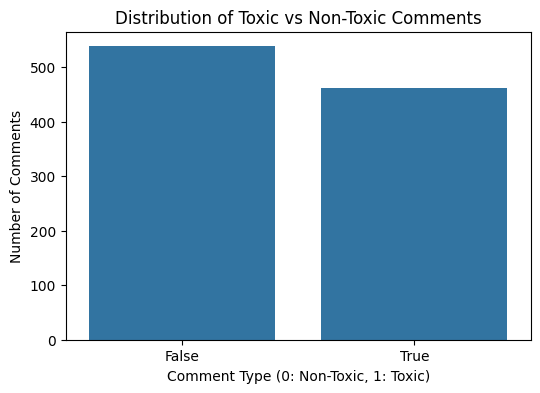

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of toxic vs non-toxic comments
plt.figure(figsize=(6, 4))
sns.countplot(x='IsToxic', data=df)
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.xlabel('Comment Type (0: Non-Toxic, 1: Toxic)')
plt.ylabel('Number of Comments')
plt.show()


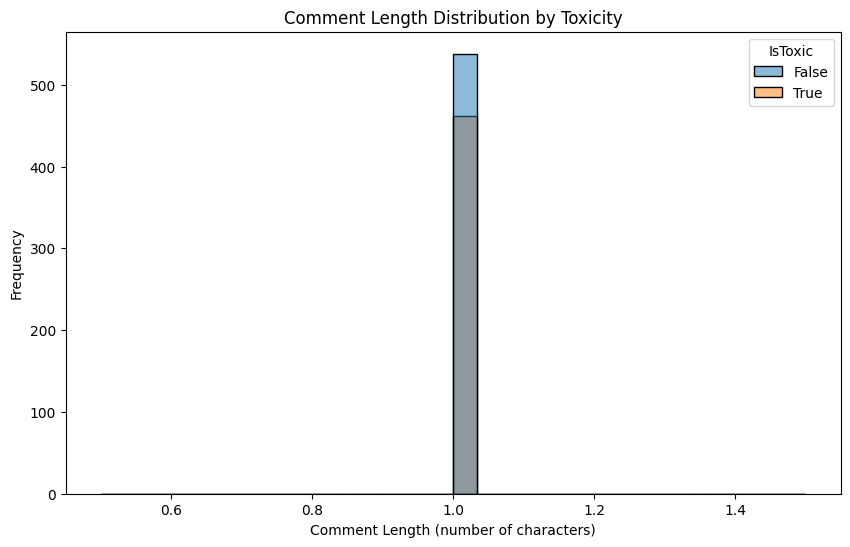

In [93]:
# Add a new column for comment length
df['text_length'] = df['text_length'].apply(lambda x: len(str(x)))

# Plot comment length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='IsToxic', bins=30, kde=False)
plt.title('Comment Length Distribution by Toxicity')
plt.xlabel('Comment Length (number of characters)')
plt.ylabel('Frequency')
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_28944\2960153970.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


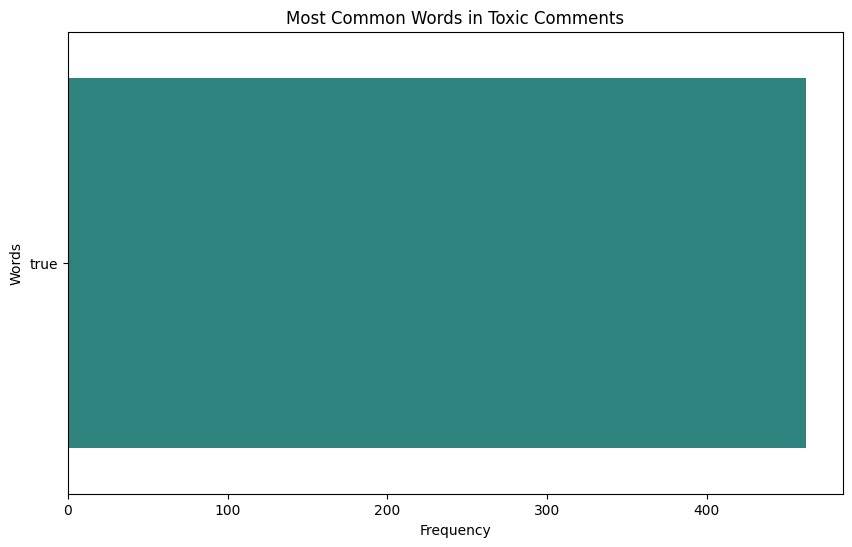

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [101]:
# This code snippet is performing the following tasks:
# This code snippet is performing the following tasks:
from sklearn.feature_extraction.text import CountVectorizer

# Define a function to plot the most common words
def plot_most_common_words(text_data, title, n_words=20):
    vectorizer = CountVectorizer(max_features=n_words, stop_words='english')
    bag_of_words = vectorizer.fit_transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    words = [item[0] for item in words_freq]
    counts = [item[1] for item in words_freq]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(f'Most Common Words in {title}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plot most common words in toxic comments
plot_most_common_words(toxic_comments, 'Toxic Comments')

# Plot most common words in non-toxic comments
plot_most_common_words(non_toxic_comments, 'Non-Toxic Comments')


# 2. Convert Text to Numerical Format

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [21]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')


In [23]:
# Fit the tokenizer on the cleaned comments
tokenizer.fit_on_texts(df['CommentId'])


In [25]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['CommentId'])


In [26]:
# Pad sequences to ensure consistent input length
max_len = 100  # Maximum length of a comment after padding
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [27]:
# splitting the data into the training and testing set 


X = padded_sequences
y = df['IsToxic']

In [29]:
# split the dataset 


x_train , x_test , y_train, y_test = train_test_split(X, y , test_size=0.2 , random_state=42)

In [30]:
# Build and train the Model 


In [31]:
# 1. Define the Model Architecture 


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [33]:
# Define the LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [35]:
# Compiling the Model 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [3]:
# Print model summary
model.summary()

NameError: name 'model' is not defined

In [37]:
# train the Model 


In [38]:
history = model.fit(x_train, y_train, epochs=5 , batch_size=32 , validation_data=(x_test, y_test))

Epoch 1/5
25/25 [==============================] - 7s 131ms/step - loss: 0.6918 - accuracy: 0.5450 - val_loss: 0.6990 - val_accuracy: 0.4650
Epoch 2/5
25/25 [==============================] - 2s 97ms/step - loss: 0.6887 - accuracy: 0.5562 - val_loss: 0.7052 - val_accuracy: 0.4650
Epoch 3/5
25/25 [==============================] - 3s 107ms/step - loss: 0.6890 - accuracy: 0.5587 - val_loss: 0.7089 - val_accuracy: 0.4650
Epoch 4/5
25/25 [==============================] - 2s 91ms/step - loss: 0.6893 - accuracy: 0.5562 - val_loss: 0.6987 - val_accuracy: 0.4650
Epoch 5/5
25/25 [==============================] - 2s 99ms/step - loss: 0.6873 - accuracy: 0.5562 - val_loss: 0.7167 - val_accuracy: 0.4650


In [39]:
# 3. Visualize Training Progress

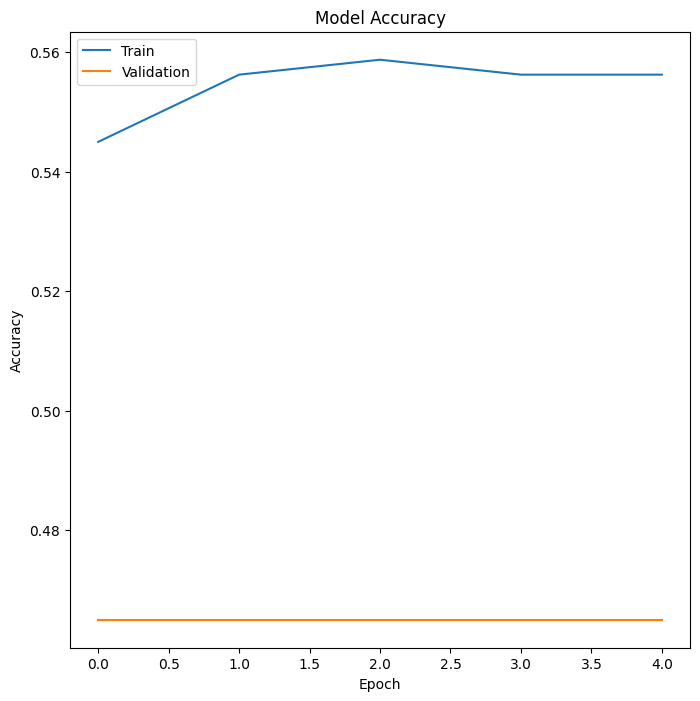

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [49]:
#  Evaluate the Model 

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


7/7 [==============================] - 0s 30ms/step - loss: 0.7167 - accuracy: 0.4650
Test Accuracy: 46.50%


In [51]:
from sklearn.metrics import classification_report

# Predict on the test data
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))


7/7 [==============================] - 1s 45ms/step
              precision    recall  f1-score   support

       False       0.47      1.00      0.63        93
        True       0.00      0.00      0.00       107

    accuracy                           0.47       200
   macro avg       0.23      0.50      0.32       200
weighted avg       0.22      0.47      0.30       200



c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [53]:
# Predict on the test data
y_pred = (model.predict(x_test) > 0.5).astype("int32")

7/7 [==============================] - 0s 23ms/step


In [54]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.47      1.00      0.63        93
        True       0.00      0.00      0.00       107

    accuracy                           0.47       200
   macro avg       0.23      0.50      0.32       200
weighted avg       0.22      0.47      0.30       200



c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [6]:
import pandas as pd

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [1]:
# this is the new file in which the code is updated and still it is good 




In [2]:

#  this is the second line of the comment where we are starting the other things 

In [3]:

#  this is the new day code updated 

In [4]:
#  this will create the heavy commits and then we will move on 

In [5]:
#  from this line your next things will start with  good things to happen in your  place just you have to folloe the

In [6]:
# things regularly dont miss any opportunity and try your best and give your best dont fall in any ones trap dont be someone who had not tried 